In [ ]:
# default_exp nbeats.learner

In [ ]:
# hide
import sys

sys.path.append("..")
import pandas as pd
%load_ext autoreload
%autoreload 2

/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/home/tako/dev/env37/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# N-Beats Learner

> A basic architecture for time series forecasting.


The approach is based on https://arxiv.org/abs/1905.10437


In [ ]:
# hide
from nbdev.showdoc import *
from fastcore.test import *

In [ ]:
#export
from fastcore.utils import *
from fastcore.imports import *
from fastai2.basics import *
from fastai2.callback.hook import num_features_model
from fastai2.callback.all import *
from fastai2.torch_core import *
from torch.autograd import Variable
from fastseq.all import *

from fastseq.nbeats.model import *
from fastseq.nbeats.metrics import *

## Learner

In [ ]:
# export
# from fastai2.basics import *
# from fastseq.all import *

@delegates(NBeatsNet.__init__)
def nbeats_learner(dbunch:TSDataLoaders, output_channels=None, metrics=None,cbs=None, b_loss=0., loss_func=None, **kwargs):
    "Build a N-Beats style learner"  
    model = NBeatsNet(
        device = dbunch.train.device,
        horizon = dbunch.train.horizon,
        lookback = dbunch.train.lookback, 
        **kwargs
       )
    
    loss_func = ifnone(loss_func, F.mse_loss)
    cbs = L(cbs)
    if b_loss != 0:
        cbs.append(NBeatsBLoss(b_loss))
    learn = Learner(dbunch, model, loss_func=loss_func, opt_func= Adam, 
                    metrics=L(metrics)+L(mae, smape, NBeatsBackwards(), NBeatsTheta()),
                    cbs=L(NBeatsTrainer(),NBeatsAttention())+cbs
                   )
    learn.lh = (dbunch.train.lookback/dbunch.train.horizon)
    return learn

# Example

Train:40; Valid: 20; Test 10


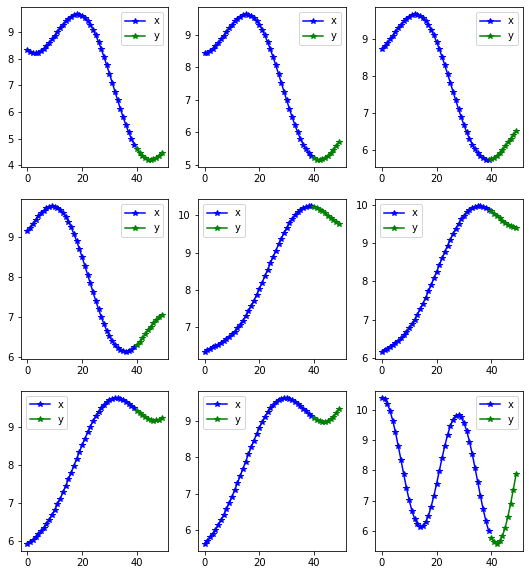

In [ ]:
horizon, lookback = 10,40
items = dummy_data_generator(75, 10, nrows=10)
data = TSDataLoaders.from_items(items, horizon = horizon, lookback=lookback, step=3, valid_pct=.5
                               )
data.show_batch()

In [ ]:
learn = nbeats_learner(data, b_loss=.8)

epoch,train_loss,valid_loss,mae,smape,b_loss,theta,time
0,114.831009,6.061424,1.271289,1.449980,4.004669,0.006660,00:00
1,188.219543,5.022939,1.241378,1.407528,2.840628,0.005530,00:00
2,251.585968,6.220788,1.219899,1.382062,4.447825,0.005275,00:00
3,301.789001,8.164988,1.204559,1.366644,6.964821,0.005607,00:00
4,337.050140,9.947988,1.196434,1.361907,9.249075,0.005931,00:00


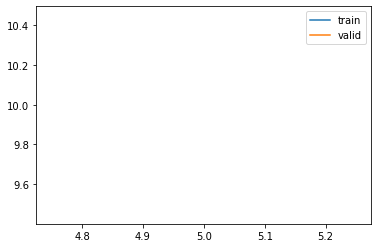

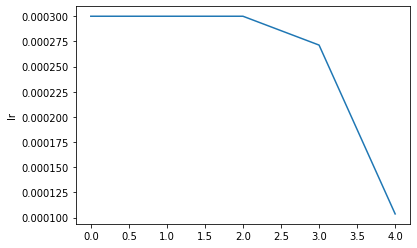

In [ ]:
learn.fit_flat_cos(5, 3e-4, pct_start=.5)
learn.recorder.plot_loss()
learn.recorder.plot_sched()

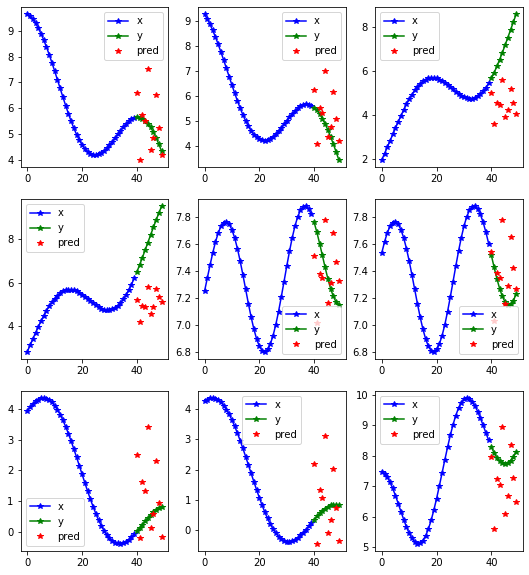

In [ ]:
learn.show_results()

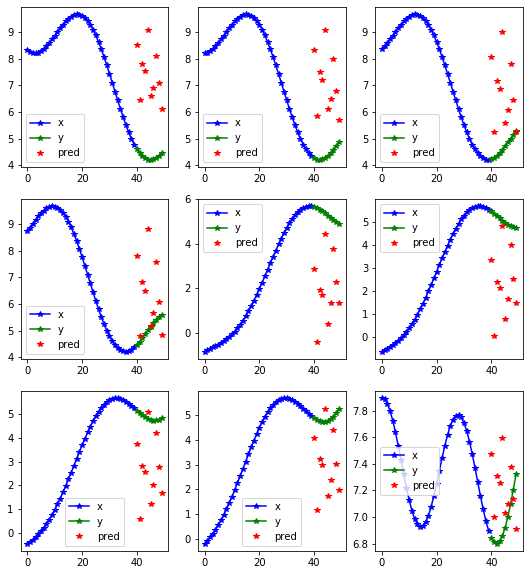

In [ ]:
learn.show_results(0)

In [ ]:
learn.n_beats_attention.means()

,trend0_0,trend0_1,trend0_2,seaonality1_0,seaonality1_1,seaonality1_2
theta_0_mean,-0.09043057,0.011914569,-0.060512178,0.40625364,0.024596523,-0.018922158
theta_0_std,0.007115417,0.053517435,0.049572166,0.9209795,0.16646473,0.12734236
theta_1_mean,-0.09026203,0.011535562,-0.05875918,-0.30969775,-0.04505873,-0.018922158
theta_1_std,0.007205681,0.052771974,0.053564977,0.9320944,0.16424295,0.12734236
theta_2_mean,-0.044249263,-0.010818002,-0.017408691,0.4085536,0.045325443,0.018922158
theta_2_std,0.078626215,0.030831141,0.03700089,0.91759044,0.16417836,0.12734236
att_mean,0.950241,0.484526,0.982065,1,0.244427,0.0228483
att_std,0.0369812,0.367107,0.0347626,0,0.132059,0.135647


In [ ]:
# hide
from nbdev.export import *
notebook2script()

Converted 00_core.ipynb.
Converted 01_data.external.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 05_nbeats.models.ipynb.
Converted 06_nbeats.metrics.ipynb.
Converted 07_nbeats.learner.ipynb.
Converted 08_nbeats.interpret.ipynb.
Converted 11_metrics.ipynb.
Converted index.ipynb.
